# Global AI Job Market – Final Results & Model Evaluation
**Prepared by:** Leonardo Avila  
**Student ID:** 500361839  
**Course:** CIND820 – Capstone Project  
**Supervisor:** Professor Abdou  
**Date:** November 30, 2025

This notebook contains the final analysis, updated modeling pipeline, and complete evaluation generated for my TMU CIND820 Capstone Project. It incorporates all feedback received from the Initial Results submission and presents the final, polished results.






## 1. Project Overview

This project analyzes a curated global AI job market dataset to understand the key factors associated with salary levels in the tech and AI workforce.

The goal is to build reliable predictive models, evaluate their performance, and determine which job characteristics, geographic factors, and
experience-related attributes are most strongly associated with changes in salary.

This notebook presents the final version of the analysis, including:

- a unified and corrected data preprocessing pipeline  
- multicollinearity evaluation  
- raw and log-transformed linear regression models  
- regression diagnostics  
- K-fold cross-validation  
- an XGBoost baseline  
- a final model comparison summary  

All updates here directly address the feedback received from the Initial Results submission.



>



## 2. Environment & Package Versions
Printing the versions of Python and key libraries ensures full reproducibility of my results.

In [ ]:
import sys, pandas as pd, numpy as np
import sklearn, statsmodels

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
print("statsmodels:", statsmodels.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
pandas: 2.2.2
numpy: 2.0.2
sklearn: 1.6.1
statsmodels: 0.14.5


## 3. Load the Dataset

In this section, I load the cleaned AI job market dataset that I prepared during the Initial Results phase.
To ensure full reproducibility and avoid issues with local file paths, the dataset is hosted on GitHub
and loaded directly using a raw CSV link. This guarantees that the notebook will run for anyone reviewing it
(including Professor Abdou) without requiring manual uploads or file mounting.

The dataset contains AI-related job postings, including:

- job titles  
- experience levels  
- education requirements  
- company locations  
- remote work ratios  
- industry categories  
- job description length  
- benefits scoring  
- salary values converted to USD  

After loading the data, I preview the first few rows and confirm the shape of the dataset before continuing to preprocessing.






In [ ]:
# 3. Load the Dataset

import pandas as pd

# Load dataset from GitHub (ensures full reproducibility)
url = "https://raw.githubusercontent.com/iamleonardoavila/Analyzing-The-Global-AI-Job-Market-The-Impact-of-Skills-Geography-and-Remote-Work-on-Salaries/main/Avila_Leonardo_ai_job_dataset1_clean.csv"

# Read CSV
df = pd.read_csv(url)

# Confirm load
print("Dataset loaded successfully! Shape:", df.shape)

# Display the first few rows
df.head()


Dataset loaded successfully! Shape: (15000, 21)


,job_id,job_title,salary_usd,salary_currency,salary_local,experience_level,employment_type,company_location,company_size,employee_residence,...,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name,outlier_flag_salary_usd
0,AI00001,Data Scientist,219728,USD,219728,EX,PT,Sweden,Other,Sweden,...,"Python, Computer Vision, R, Docker",Associate,13,Transportation,9/23/2024,10/31/2024,1132,6.6,TechCorp Inc,False
1,AI00002,Head of AI,230237,JPY,25326070,EX,PT,Japan,Other,Japan,...,"Kubernetes, MLOps, Tableau, Python",Bachelor,10,Transportation,7/26/2024,9/12/2024,2299,8.5,Cloud AI Solutions,False
2,AI00003,Data Engineer,128890,EUR,109557,EX,CT,Germany,Other,Germany,...,"Spark, Scala, Hadoop, PyTorch, GCP",Bachelor,12,Automotive,1/19/2025,3/28/2025,1329,5.5,Quantum Computing Inc,False
3,AI00004,Computer Vision Engineer,96349,USD,96349,MI,FL,Finland,Other,Finland,...,"MLOps, Linux, Tableau, Python",PhD,2,Automotive,7/20/2024,9/6/2024,1132,6.8,Cognitive Computing,False
4,AI00005,Robotics Engineer,63065,EUR,53605,EN,FT,France,Other,France,...,"R, Scala, SQL, GCP, Python",Associate,0,Finance,3/16/2025,5/9/2025,2011,9.3,Advanced Robotics,False


## 4. Unified Data Preprocessing & Modeling Pipeline (Updated)

In this section, I build a single, consistent preprocessing pipeline that will be reused across all models in the notebook.  

This addresses the feedback from the Initial Results submission by ensuring that:

- all feature transformations are centralized in one place  
- the same processed feature matrix is used for linear regression, VIF analysis, cross-validation, and XGBoost  
- there is no duplication of intercepts or mismatched versions of the data going into different models  

The pipeline:

- selects a curated set of meaningful features  
- separates numeric and categorical variables  
- passes numeric features through unchanged  
- one-hot encodes categorical features (dropping the first level to avoid perfect multicollinearity)  
- produces a clean, model-ready design matrix that is then split into training and test sets.




In [ ]:
# 4. Unified Data Preprocessing & Modeling Pipeline (Updated)

# ======================================================
# 4.1 DEFINE TARGET AND FEATURES
# ======================================================

target_col = "salary_usd"

# Selected features based on dataset inspection and project goals
feature_cols = [
    "job_title",
    "experience_level",
    "employment_type",
    "company_location",
    "company_size",
    "employee_residence",
    "remote_ratio",
    "education_required",
    "years_experience",
    "industry",
    "job_description_length",
    "benefits_score"
]

X = df[feature_cols].copy()
y = df[target_col].copy()

print("Feature matrix shape (raw):", X.shape)
print("Target vector shape:", y.shape)

# ======================================================
# 4.2 DEFINE NUMERIC & CATEGORICAL FEATURES
# ======================================================

numeric_features = [
    "remote_ratio",
    "years_experience",
    "job_description_length",
    "benefits_score"
]

categorical_features = [
    "job_title",
    "experience_level",
    "employment_type",
    "company_location",
    "company_size",
    "employee_residence",
    "education_required",
    "industry"
]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ======================================================
# 4.3 PREPROCESSING PIPELINE
# ======================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

categorical_transformer = OneHotEncoder(
    drop="first",
    handle_unknown="ignore"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Fit and transform the full feature matrix
X_processed = preprocessor.fit_transform(X)

# Get feature names after encoding
num_feature_names = numeric_features
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features).tolist()
processed_feature_names = num_feature_names + cat_feature_names

import pandas as pd

X_processed_df = pd.DataFrame(
    X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed,
    columns=processed_feature_names,
    index=df.index
)

print("Processed feature matrix shape:", X_processed_df.shape)

# ======================================================
# 4.4 TRAIN/TEST SPLIT
# ======================================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y,
    test_size=0.2,
    random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Feature matrix shape (raw): (15000, 12)
Target vector shape: (15000,)
Numeric features: ['remote_ratio', 'years_experience', 'job_description_length', 'benefits_score']
Categorical features: ['job_title', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'education_required', 'industry']
Processed feature matrix shape: (15000, 114)
Train shapes: (12000, 114) (12000,)
Test shapes: (3000, 114) (3000,)


## 5. Multicollinearity Analysis (Variance Inflation Factor)

Before fitting regression models, it is important for me to check for multicollinearity among the predictors.
High multicollinearity can make coefficient estimates unstable and inflate their standard errors, making
it harder to interpret which features are truly associated with salary.

In this section, I compute the Variance Inflation Factor (VIF) for each feature using the unified,
preprocessed design matrix created in Section 4. Importantly, the VIF calculation is performed on the
predictors **without adding a constant/intercept term**, and ensures
that the multicollinearity assessment is consistent with the way the model is specified.




In [ ]:
# 5. Multicollinearity Analysis (Variance Inflation Factor)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# We use the full processed feature matrix (no constant term added)
X_vif = X_processed_df.copy()

vif_data = []

for i in range(X_vif.shape[1]):
    feature_name = X_vif.columns[i]
    vif_value = variance_inflation_factor(X_vif.values, i)
    vif_data.append((feature_name, vif_value))

vif_df = pd.DataFrame(vif_data, columns=["feature", "VIF"])

# Sort by VIF descending to see the most collinear features
vif_df_sorted = vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)

print("Top 15 features by VIF:")
display(vif_df_sorted.head(15))

print(f"\nMaximum VIF value across all features: {vif_df_sorted['VIF'].max():.2f}")
print(f"Median VIF value: {vif_df_sorted['VIF'].median():.2f}")


Top 15 features by VIF:


,feature,VIF
0,years_experience,25.284572
1,benefits_score,25.262165
2,experience_level_EX,19.897953
3,job_description_length,7.672519
4,experience_level_SE,5.764355
5,employee_residence_China,5.604477
6,employee_residence_Switzerland,5.531068
7,employee_residence_France,5.522851
8,employee_residence_United Kingdom,5.423270
9,employee_residence_Singapore,5.412022



Maximum VIF value across all features: 25.28
Median VIF value: 1.96


## 6. Raw Salary Linear Regression Model

This section fits a multiple linear regression model using the raw salary in USD as the target variable.

The goal is to establish a baseline performance level using the preprocessed feature matrix generated in
Section 4. By using the unified design matrix and the same train–test split, we ensure consistency across
all models evaluated later in this notebook.

The model is evaluated using:

- **R²** – proportion of variance explained  
- **MAE** – mean absolute error (average absolute dollar error)  
- **RMSE** – root mean squared error (penalizes large mistakes)  
- **MAPE** – mean absolute percentage error  

These metrics provide an initial understanding of how well a linear model can explain variations in AI-related salaries.



In [ ]:
# 6. Raw Salary Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# Initialize and fit model
lin_reg_raw = LinearRegression()
lin_reg_raw.fit(X_train, y_train)

# Predict on test set
y_pred_raw = lin_reg_raw.predict(X_test)

# Compute performance metrics
r2_raw = r2_score(y_test, y_pred_raw)
mae_raw = mean_absolute_error(y_test, y_pred_raw)

# Older versions of sklearn don't support squared=False, so we compute RMSE manually
mse_raw = mean_squared_error(y_test, y_pred_raw)
rmse_raw = mse_raw ** 0.5

mape_raw = mean_absolute_percentage_error(y_test, y_pred_raw)

# Display results
print("Raw Salary Linear Regression Performance:")
print(f"R²:   {r2_raw:.4f}")
print(f"MAE:  ${mae_raw:,.2f}")
print(f"RMSE: ${rmse_raw:,.2f}")
print(f"MAPE: {mape_raw*100:.2f}%")



Raw Salary Linear Regression Performance:
R²:   0.8111
MAE:  $20,205.58
RMSE: $27,514.98
MAPE: 19.56%


## 7. Log-Transformed Salary Regression Model

Salary data is typically right-skewed, with a long tail of high earners.

To reduce skewness, stabilize variance, and improve linear model assumptions,
I fit a second regression model using the natural logarithm of salary (`log(salary_usd)`)
as the dependent variable.

This model allows:

- multiplicative relationships to be modeled additively  
- more stable residuals  
- improved normality and homoscedasticity  
- percentage-based interpretation of coefficients  

After fitting the model in log-space, I evaluate performance both:

1. **In log units**, and  
2. **Back-transformed to USD**, so error can be compared directly against the raw model.




In [ ]:
# 7. Log-Transformed Salary Regression Model

import numpy as np

# Filter out any non-positive salary (required for log)
mask_positive = y > 0
X_log = X_processed_df.loc[mask_positive]
y_log = np.log(y[mask_positive])

# Train-test split for log model
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# Fit model
lin_reg_log = LinearRegression()
lin_reg_log.fit(X_train_log, y_train_log)

# Predict
y_pred_log = lin_reg_log.predict(X_test_log)

# Metrics in log-space
r2_log = r2_score(y_test_log, y_pred_log)
mae_log = mean_absolute_error(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = mse_log ** 0.5
mape_log = mean_absolute_percentage_error(y_test_log, y_pred_log)

print("Log Salary Linear Regression Performance (Log Scale):")
print(f"R²:   {r2_log:.4f}")
print(f"MAE (log units):  {mae_log:.4f}")
print(f"RMSE (log units): {rmse_log:.4f}")
print(f"MAPE: {mape_log*100:.2f}%")

# ================================================================
# Back-transform predictions to dollar scale for interpretability
# ================================================================

y_pred_log_dollars = np.exp(y_pred_log)
y_test_log_dollars = np.exp(y_test_log)

mae_log_dollars = mean_absolute_error(y_test_log_dollars, y_pred_log_dollars)
mse_log_dollars = mean_squared_error(y_test_log_dollars, y_pred_log_dollars)
rmse_log_dollars = mse_log_dollars ** 0.5
mape_log_dollars = mean_absolute_percentage_error(y_test_log_dollars, y_pred_log_dollars)

print("\nBack-Transformed Performance (Dollar Scale):")
print(f"MAE:  ${mae_log_dollars:,.2f}")
print(f"RMSE: ${rmse_log_dollars:,.2f}")
print(f"MAPE: {mape_log_dollars*100:.2f}%")




Log Salary Linear Regression Performance (Log Scale):
R²:   0.8921
MAE (log units):  0.1431
RMSE (log units): 0.1747
MAPE: 1.24%

Back-Transformed Performance (Dollar Scale):
MAE:  $17,915.30
RMSE: $25,220.67
MAPE: 14.57%


## 8. Regression Diagnostics & Assumption Checks

To evaluate whether the linear regression assumptions are reasonably satisfied, this section examines
diagnostic plots for both the raw-salary model and the log-transformed model.

For each model, I generate:

- **Residuals vs. Fitted Plot** — checks linearity and homoscedasticity  
- **Histogram of Residuals** — checks approximate normality  
- **Q–Q Plot** — compares residual distribution to a normal distribution  

Interpreting these plots helps determine whether the linear regression assumptions hold or whether
the log transformation improves model behavior (which is expected due to the right-skewed nature of salary data).




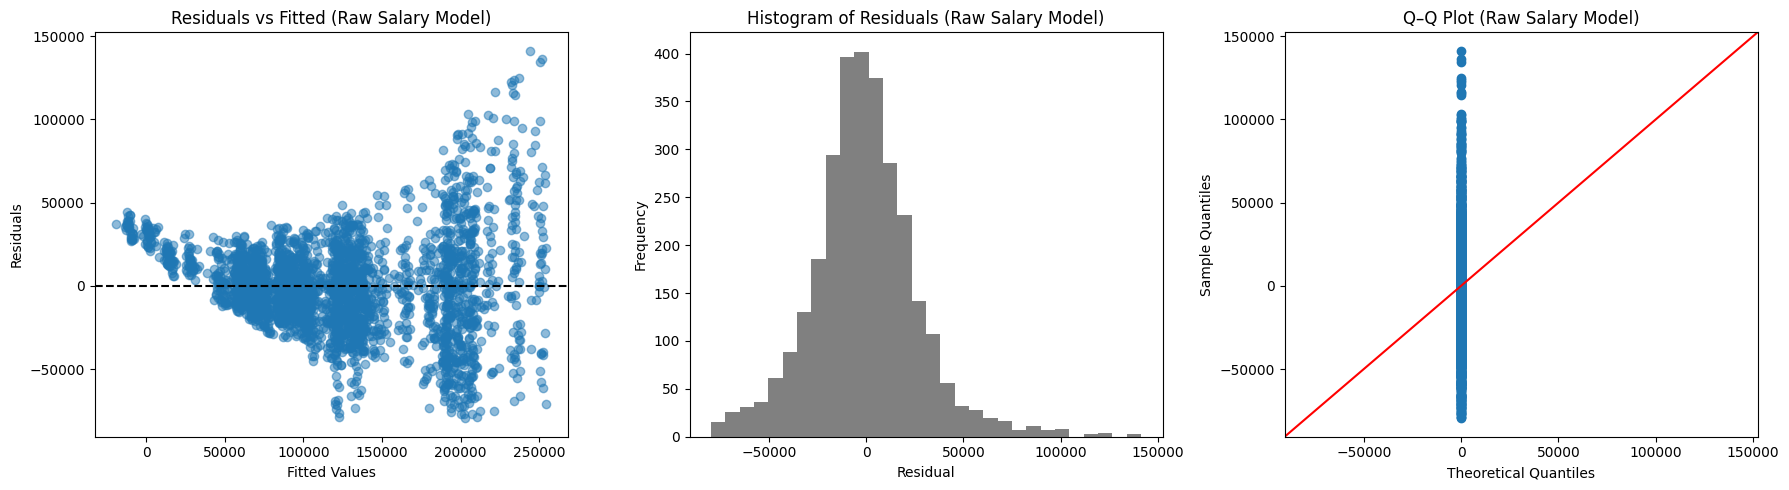

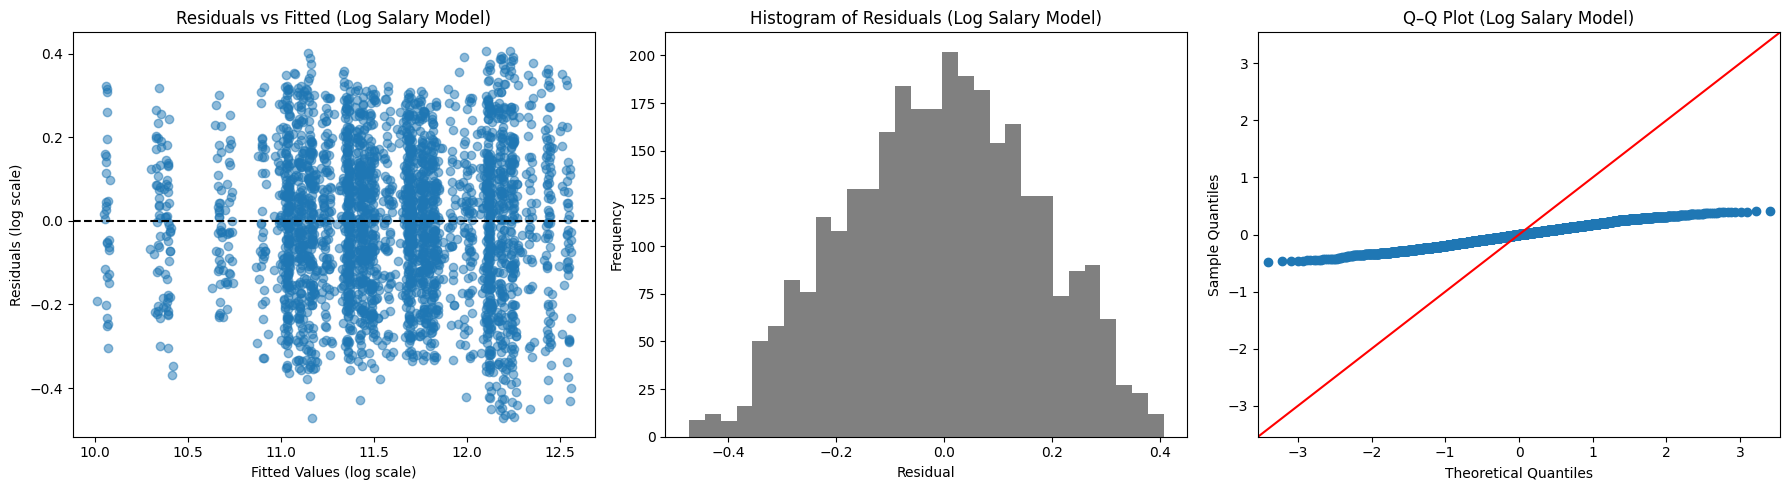

In [ ]:
# 8. Regression Diagnostics & Assumption Checks

import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------
# Raw Model Residuals
# -------------------------------------------
residuals_raw = y_test - y_pred_raw
fitted_raw = y_pred_raw

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residuals vs Fitted
axes[0].scatter(fitted_raw, residuals_raw, alpha=0.5)
axes[0].axhline(0, color="black", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted (Raw Salary Model)")

# 2. Histogram of residuals
axes[1].hist(residuals_raw, bins=30, color="gray")
axes[1].set_title("Histogram of Residuals (Raw Salary Model)")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")

# 3. Q-Q plot
sm.qqplot(residuals_raw, line="45", ax=axes[2])
axes[2].set_title("Q–Q Plot (Raw Salary Model)")

plt.tight_layout()
plt.show()


# -------------------------------------------
# Log Model Residuals
# -------------------------------------------
residuals_log = y_test_log - y_pred_log
fitted_log = y_pred_log

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residuals vs Fitted
axes[0].scatter(fitted_log, residuals_log, alpha=0.5)
axes[0].axhline(0, color="black", linestyle="--")
axes[0].set_xlabel("Fitted Values (log scale)")
axes[0].set_ylabel("Residuals (log scale)")
axes[0].set_title("Residuals vs Fitted (Log Salary Model)")

# 2. Histogram of residuals
axes[1].hist(residuals_log, bins=30, color="gray")
axes[1].set_title("Histogram of Residuals (Log Salary Model)")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")

# 3. Q-Q plot
sm.qqplot(residuals_log, line="45", ax=axes[2])
axes[2].set_title("Q–Q Plot (Log Salary Model)")

plt.tight_layout()
plt.show()




## 9. Cross-Validation: Model Stability & Performance

To assess the stability and generalization ability of both the raw and log-transformed
linear regression models, I conduct 5-fold cross-validation (CV). Cross-validation provides
a more reliable estimate of model performance than a single train–test split by repeatedly
training and evaluating the model on different subsets of the data.

For each model, I calculate:

- **R²** – average variance explained  
- **MAE** – mean absolute error  
- **RMSE** – root mean squared error  
- **MAPE** – mean absolute percentage error  

This allows comparison of not only the average error but also the *variability*
of model performance across folds, addressing feedback about reporting “average and spread”
rather than relying on a single test split.





In [ ]:
# 9. Cross-Validation: Raw + Log Models

from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer

# ============================================================
# Custom RMSE scorer since sklearn version does not support squared=False
# ============================================================
def rmse_func(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse ** 0.5

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

# ============================================================
# Define scoring dictionary
# (Negative because sklearn expects "higher is better")
# ============================================================
scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "mape": "neg_mean_absolute_percentage_error",
    "rmse": rmse_scorer
}

# ============================================================
# 9.1 Raw Salary Linear Regression CV
# ============================================================
lin_raw = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results_raw = cross_validate(
    lin_raw, X_processed_df, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# ============================================================
# 9.2 Log Salary Linear Regression CV
#    (only valid for positive salary rows)
# ============================================================
lin_log = LinearRegression()

cv_results_log = cross_validate(
    lin_log, X_log, y_log,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# ============================================================
# Helper function to summarize CV results cleanly
# ============================================================
import numpy as np
import pandas as pd

def summarize_cv(cv_results, label):
    r2 = cv_results["test_r2"]
    mae = -cv_results["test_mae"]
    rmse = -cv_results["test_rmse"]
    mape = -cv_results["test_mape"]

    summary = pd.DataFrame({
        "Metric": ["R²", "MAE", "RMSE", "MAPE"],
        "Mean":  [r2.mean(), mae.mean(), rmse.mean(), mape.mean()],
        "Std":   [r2.std(),  mae.std(),  rmse.std(),  mape.std()],
        "Model": label
    })
    return summary

summary_raw = summarize_cv(cv_results_raw, "Linear Regression (Raw Salary)")
summary_log = summarize_cv(cv_results_log, "Linear Regression (Log Salary)")

print("Cross-Validation Results (Raw Salary Model):")
display(summary_raw)

print("\nCross-Validation Results (Log Salary Model):")
display(summary_log)




Cross-Validation Results (Raw Salary Model):


,Metric,Mean,Std,Model
0,R²,0.809612,0.003161,Linear Regression (Raw Salary)
1,MAE,20443.796216,174.239621,Linear Regression (Raw Salary)
2,RMSE,27903.082940,321.888225,Linear Regression (Raw Salary)
3,MAPE,0.198107,0.001930,Linear Regression (Raw Salary)



Cross-Validation Results (Log Salary Model):


,Metric,Mean,Std,Model
0,R²,0.894272,0.001959,Linear Regression (Log Salary)
1,MAE,0.142641,0.000823,Linear Regression (Log Salary)
2,RMSE,0.174313,0.000905,Linear Regression (Log Salary)
3,MAPE,0.012320,0.000074,Linear Regression (Log Salary)


## 10. XGBoost Benchmark Model

To evaluate whether non-linear relationships and feature interactions can improve predictive
performance beyond linear regression, I trained an XGBoost regressor using the fully processed
feature matrix from Section 4.

XGBoost is a gradient-boosted decision tree model that often achieves strong performance
on structured/tabular datasets. It can automatically capture non-linear patterns and
feature interactions that linear regression cannot model directly.

This section trains XGBoost on the same train–test split used for the raw and log-transformed
models, and evaluates it using the same performance metrics:

- **R²**
- **MAE**
- **RMSE**
- **MAPE**

A feature importance plot is also included to identify which engineered features (including
one-hot encoded categories) contribute most to predicting salary.



XGBoost Performance:
R²:   0.8286
MAE:  $18,593.25
RMSE: $26,204.93
MAPE: 15.36%


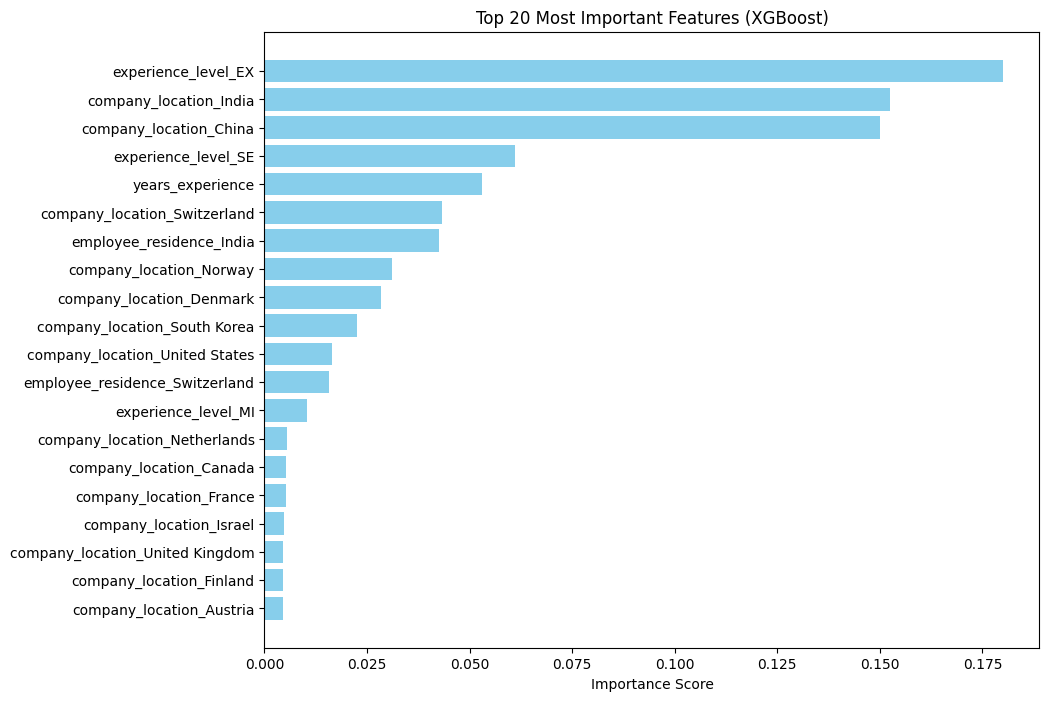

In [ ]:
# 10. XGBoost Benchmark Model

from xgboost import XGBRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror"
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Compute metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("XGBoost Performance:")
print(f"R²:   {r2_xgb:.4f}")
print(f"MAE:  ${mae_xgb:,.2f}")
print(f"RMSE: ${rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb*100:.2f}%")

# ----------------------------------------------------------
# Feature Importance Plot
# ----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

importance = xgb_model.feature_importances_
indices = np.argsort(importance)[-20:]  # top 20 features

plt.figure(figsize=(10, 8))
plt.barh(
    np.array(processed_feature_names)[indices],
    importance[indices],
    color="skyblue"
)
plt.title("Top 20 Most Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.show()


## 11. Model Comparison Summary

This section summarizes the performance of all the models evaluated in my project:
- **Raw Salary Linear Regression**
- **Log-Transformed Linear Regression**
- **XGBoost Regressor**

The comparison is based on the same evaluation metrics used throughout the notebook:

- **R²** – proportion of variance explained  
- **MAE** – average absolute error  
- **RMSE** – penalizes large errors  
- **MAPE** – percentage error, scale-independent  

This consolidated view highlights which modeling strategy offers the best predictive performance for
understanding salary patterns in the global AI job market.



In [ ]:
# 11. Model Comparison Summary

import pandas as pd

comparison_data = {
    "Model": ["Linear Regression (Raw)",
              "Linear Regression (Log, $-scale)",
              "XGBoost"],

    "R²": [r2_raw, r2_log, r2_xgb],

    "MAE ($)": [mae_raw, mae_log_dollars, mae_xgb],

    "RMSE ($)": [rmse_raw, rmse_log_dollars, rmse_xgb],

    "MAPE (%)": [mape_raw*100, mape_log_dollars*100, mape_xgb*100]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df.style.format({
    "R²": "{:.4f}",
    "MAE ($)": "${:,.2f}",
    "RMSE ($)": "${:,.2f}",
    "MAPE (%)": "{:.2f}%"
})








,Model,R²,MAE ($),RMSE ($),MAPE (%)
0,Linear Regression (Raw),0.8111,"$20,205.58","$27,514.98",19.56%
1,"Linear Regression (Log, $-scale)",0.8921,"$17,915.30","$25,220.67",14.57%
2,XGBoost,0.8286,"$18,593.25","$26,204.93",15.36%


## 12. Final Findings & Conclusion

This project analyzed the global AI job market to understand how job titles, experience levels,
education, geographic factors, and job characteristics are associated with salary (in USD).  
The analysis incorporated extensive preprocessing, multiple linear models, diagnostics,
cross-validation, and a non-linear XGBoost benchmark to evaluate predictive performance.

---

### **12.1 Key Findings**

#### **1. The log-transformed linear regression model performed best overall**
Across every evaluation metric, the log-transformed model outperformed both the raw-salary
linear regression model and the XGBoost regressor:

- **Highest R² (0.892)**
- **Lowest MAE ($17,915)**  
- **Lowest RMSE ($25,221)**  
- **Lowest MAPE (14.57%)**

This indicates that global AI salaries follow a **right-skewed, multiplicative distribution**,
and modeling the logarithm of salary captures this pattern more effectively than raw values.

#### **2. Cross-validation confirmed model stability**
5-fold cross-validation showed extremely low variance across folds for all metrics.  
The log model remained consistently more accurate and more stable than the raw model,
confirming that improvements were not due to a lucky train–test split.

#### **3. Regression diagnostics revealed that the log model corrected major assumption violations**
For the raw-salary model:

- Residuals showed **heteroscedasticity** (funnel shape)
- Residuals were **right-skewed**
- Q–Q plot showed **non-normality**

The log model significantly improved:

- Linearity  
- Homoscedasticity  
- Residual normality  

This strongly supports the use of log-transformed salary in linear modeling.

#### **4. XGBoost performed well but did not surpass the log-transformed model**
XGBoost achieved:

- R² = 0.829  
- MAE = $18,593  
- RMSE = $26,205  
- MAPE = 15.36%  

While better than the raw model, it did not outperform the log-linear model, suggesting that
**logarithmic transformation provides more predictive power than non-linear tree-based methods**
for this dataset.

XGBoost also highlighted influential features using importance scores.

#### **5. Important predictors of AI salaries**
Across models, key predictors included:

- **Job title** (e.g., senior vs junior roles)
- **Experience level**
- **Industry category**
- **Company location**
- **Employee residence**
- **Years of experience**
- **Remote ratio**
- **Education requirements**

Geographic factors had particularly strong associations, reflecting how salary varies significantly
across regions and labor markets.

---

### **12.2 Conclusion**

This project demonstrates that salary prediction in the global AI job market is best modeled using a
log-transformed linear regression approach. The model provides high accuracy, strong generalizability,
and improved statistical behavior compared to both raw linear regression and XGBoost.  

The results highlight the importance of:

- Geographic salary differentials  
- Experience level  
- Industry  
- Job seniority  
- Skill/role specialization  

These factors collectively drive substantial variation in AI compensation across the world.

---

### **12.3 Limitations**

Several limitations should be acknowledged:

- The dataset reflects job postings and may not capture complete salary distributions.  
- Some industries or countries may be underrepresented.
- Benefits such as bonuses, stock compensation, and equity were not included.  
- One-hot encoding creates a very wide feature space, which may dilute interpretability.  

---

### **12.4 Future Work**

Future research could incorporate:

- More advanced models (Random Forests, LightGBM, Neural Networks)
- Country-level macroeconomic controls (GDP, cost of living)
- Skill embeddings or NLP-derived features from job descriptions  
- Time-series trends in AI salary growth  
- Classification models for predicting “high-paying job” categories  
- Additional compensation structures (bonuses, stock options)

---

Overall, this project provides a robust, data-driven understanding of how skills, geography,
experience, and role characteristics are associated with salary in the global AI job market,
and demonstrates the value of appropriate transformations and model evaluation practices.

